In [1]:
#GPU
import subprocess
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(sub_p_res)

Tesla T4, 15360 MiB, 15101 MiB



# **Modern Convolutional Neural Networks (ResNet-50)**

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Residual Block

In [3]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=1) #groups=16
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same', strides=strides)
        self.conv3 = tf.keras.layers.Conv2D(
            num_channels*4, kernel_size=1, strides=1)
        self.conv4 = None
        if use_1x1conv:
            self.conv4 = tf.keras.layers.Conv2D(
                num_channels*4, kernel_size=1, strides=strides)
            self.bn4 = tf.keras.layers.BatchNormalization()

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = tf.keras.activations.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        #print(X.shape, Y.shape)
        if self.conv4 is not None:
            X = self.bn4(self.conv4(X))
        Y += X
        return tf.keras.activations.relu(Y)

# ResNet Model

In [4]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels,  use_1x1conv=True))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [5]:
b2 = ResnetBlock(64, 3, first_block=True)
b3 = ResnetBlock(128, 4)
b4 = ResnetBlock(256, 6)
b5 = ResnetBlock(512, 3)

In [6]:
def net():
    model = tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same', input_shape=(96,96,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # Dropout layer added
        tf.keras.layers.Dropout(0.5),
        # The following layers are the same as b2, b3, b4, and b5 that was created earlier
        b2,
        b3,
        b4,
        b5,
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)])

    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer=tf.optimizers.Adam(learning_rate=1e-4)

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model

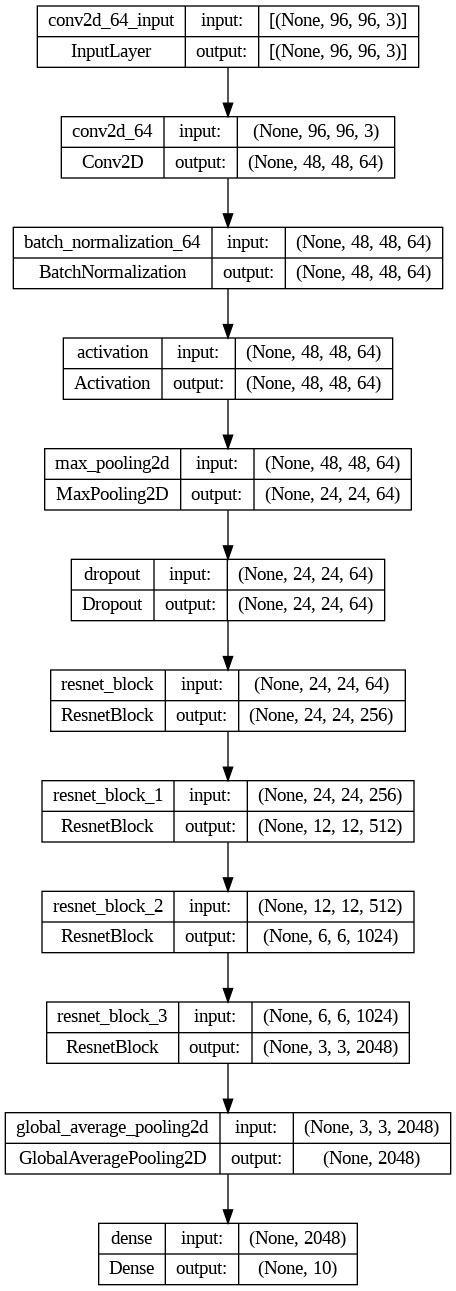

In [7]:
model = net()
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 48, 48, 64)        9472      
                                                                 
 batch_normalization_64 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 resnet_block (ResnetBlock)  (None, 24, 24, 256)       6

# **Training**

# Load the data

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))


def process_images(image, label):
    # Resize images from 32x32 to 96x96
    image = tf.image.resize(image, (96,96))
    return image, label




train_dataset = (train_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))
test_dataset = (test_dataset
                  .map(process_images)
                  .batch(batch_size=32, drop_remainder=True))

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
history = model.fit(train_dataset,
            epochs=50,
            validation_data=test_dataset)

# Visualize the training and validation accuracy

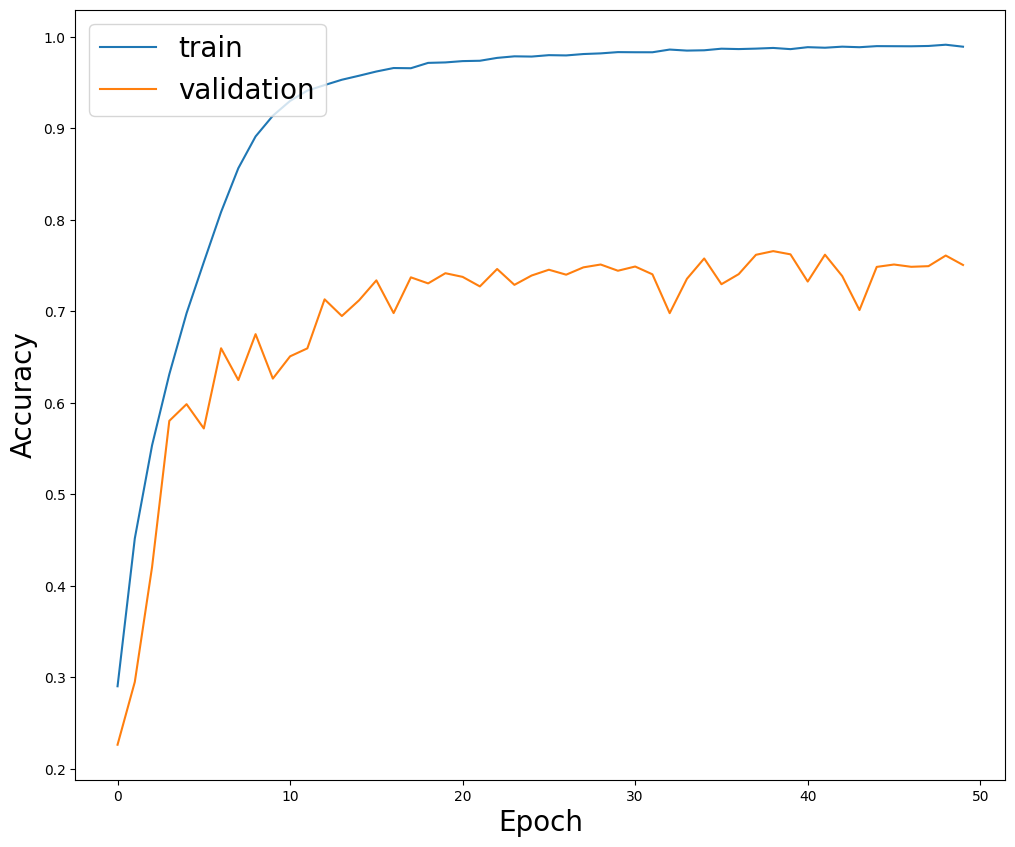

In [12]:
def plot_history(hist_):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend(["train", "validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

# Evaluate the trained model

In [13]:
score = model.evaluate(test_dataset, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.3504606485366821
Test accuracy: 0.766526460647583


# Predict using the trained model

1/1 [==============================] - 0s 26ms/step


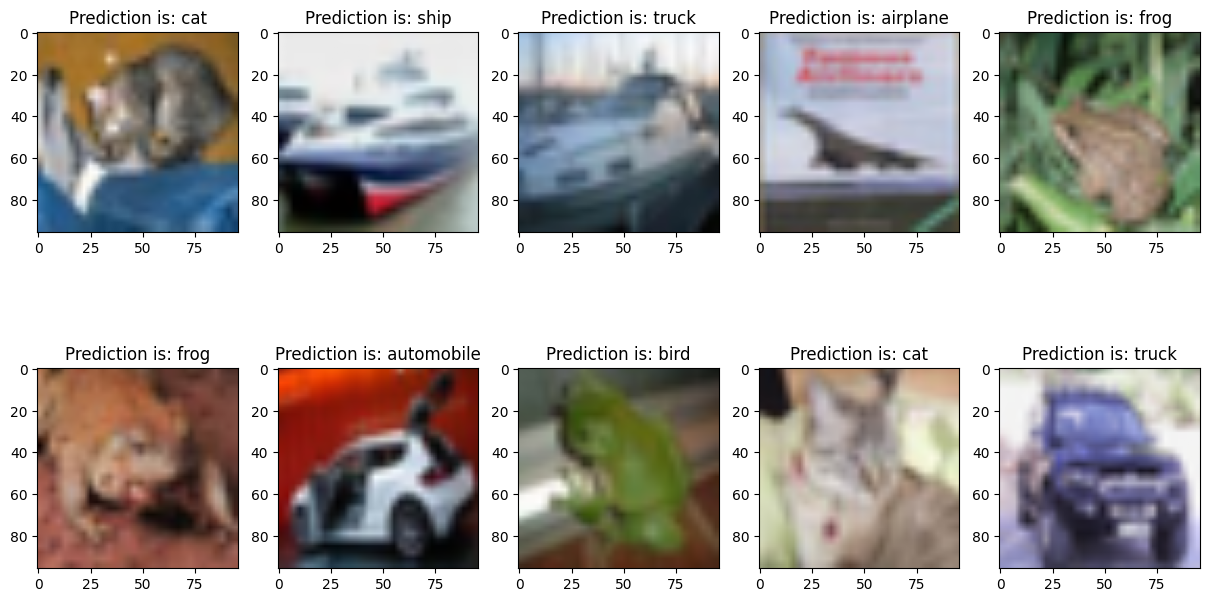

In [14]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.flatten()

# Predicts the last 10 images
for i, (image, label) in enumerate(test_dataset.take(1)):
    for i in range(10):
      ax[i].imshow(image[i])
      ax[i].set_title("Prediction is: {}".format(CLASS_NAMES[model.predict(np.reshape(image[i], (1,96,96,3))).argmax()]), fontsize=12)